In [1]:
# Dependencies
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
from tensorflow.keras import layers

import random
import sys
import time

from tensorflow.keras import utils
from tensorflow.keras import preprocessing
from os import listdir
from os.path import isdir, join

import numpy as np
import matplotlib.pyplot as plt

# Reproduction
seed = 333
np.random.seed(seed)

### Data processing

In [2]:
from os.path import join
project_path = r"C:\Users\ktub2\Dropbox\family\Kausthubh\UW Madison\Coursework\ECE 539\Project"

In [3]:
omni_path = join(project_path, r"omniglot-processed-5-train")
omni_train_datasets = dict()
omni_val_datasets = dict()

for name in listdir(omni_path):
    path = join(omni_path, name)
    if isdir(path):
        omni_train_datasets[name] = preprocessing.image_dataset_from_directory(path, label_mode='categorical',
                                                             color_mode='grayscale', batch_size=1000, image_size=(28,28),
                                                             seed=seed, validation_split=0.25, subset="training")
        omni_val_datasets[name] = preprocessing.image_dataset_from_directory(path, label_mode='categorical',
                                                             color_mode='grayscale', batch_size=1000, image_size=(28,28),
                                                             seed=seed, validation_split=0.25, subset="validation")

Found 100 files belonging to 5 classes.
Using 75 files for training.
Found 100 files belonging to 5 classes.
Using 25 files for validation.
Found 100 files belonging to 5 classes.
Using 75 files for training.
Found 100 files belonging to 5 classes.
Using 25 files for validation.
Found 100 files belonging to 5 classes.
Using 75 files for training.
Found 100 files belonging to 5 classes.
Using 25 files for validation.
Found 100 files belonging to 5 classes.
Using 75 files for training.
Found 100 files belonging to 5 classes.
Using 25 files for validation.
Found 100 files belonging to 5 classes.
Using 75 files for training.
Found 100 files belonging to 5 classes.
Using 25 files for validation.
Found 100 files belonging to 5 classes.
Using 75 files for training.
Found 100 files belonging to 5 classes.
Using 25 files for validation.
Found 100 files belonging to 5 classes.
Using 75 files for training.
Found 100 files belonging to 5 classes.
Using 25 files for validation.
Found 100 files belo

In [4]:
def dataset_to_tensors(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs.extend(x)
        ys.extend(y)
    # xs = np.array(xs)
    # ys = np.array(ys)
    return tf.convert_to_tensor(xs), tf.convert_to_tensor(ys)

xs, ys = dataset_to_tensors(omni_val_datasets['Grantha'])
print(xs.shape, ys.shape)

(25, 28, 28, 1) (25, 5)


In [5]:
omni_train_data = []
omni_train_labels = []
omni_val_data = []
omni_val_labels = []
for i in omni_train_datasets.keys():
    xs,ys = dataset_to_tensors(omni_train_datasets[i])
    omni_train_data.append(xs)
    omni_train_labels.append(ys)
    print('Train dataset converted')
    xs,ys = dataset_to_tensors(omni_val_datasets[i])
    omni_val_data.append(xs)
    omni_val_labels.append(ys)
    print('Val dataset converted')

Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted


In [14]:
complete_datasets = []
for i in range(len(omni_train_data)):
    if(len(omni_val_data[i]) == 25):
        complete_datasets.append( (omni_train_data[i],omni_train_labels[i],omni_val_data[i],omni_val_labels[i]) )

### Model definition and relevant functions

In [15]:
def create_model():
    relu_initializer = tf.keras.initializers.HeNormal()
    softmax_initializer = tf.keras.initializers.GlorotNormal()
    
    inputs = keras.Input(shape=(28,28,1))
    for i in range(4):
        if(i == 0):
            x = layers.Conv2D(64, (3,3), kernel_initializer=relu_initializer, bias_initializer='zeros', 
                              activation='relu', padding='same')(inputs)
        else:
            x = layers.Conv2D(64, (3,3), kernel_initializer=relu_initializer, bias_initializer='zeros', 
                              activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(5, kernel_initializer=softmax_initializer)(x)
    outputs = layers.Softmax()(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='maml_model')
    return model

In [16]:
def compute_loss(model, x, y, loss_fn=keras.losses.CategoricalCrossentropy()):
    logits = model(x)
    loss = loss_fn(y, logits)
    return loss

In [17]:
meow = create_model()
meow.summary()

Model: "maml_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0

### Meta Learning

In [19]:
lr = 0.001
alpha = 0.1
num_tasks = 15
epochs = 100
inner_epochs = 3
i = 0
all_losses = []
optimizer_inner = keras.optimizers.SGD(learning_rate=alpha)
optimizer_outer = keras.optimizers.Adam(learning_rate=lr)

model = create_model()
model.compile()

for epoch in range(epochs):
    all_meta_gradients = []
    total_loss = 0
    
    for task in random.sample(complete_datasets,num_tasks):
        train_data, train_labels, test_data, test_labels = task
        
        with tf.GradientTape() as test_tape:
            model_copy = create_model()
            model_copy.set_weights(model.get_weights())
            model_copy.compile(optimizer=optimizer_inner, loss=tf.keras.losses.CategoricalCrossentropy())
            inner_history = model_copy.fit(train_data, train_labels, epochs=inner_epochs, verbose=0)
            test_loss = compute_loss(model_copy, test_data, test_labels)
            total_loss += test_loss
            i += 1
        print('.',end='')
        meta_gradients = test_tape.gradient(test_loss, model_copy.trainable_weights)
        all_meta_gradients.append(meta_gradients)
      
    print('')
    print('Gradient check: '+str(all_meta_gradients[0][0][0,0,0,0].numpy()))
    sum_meta_gradients = all_meta_gradients[0]
    for i in range(1,len(all_meta_gradients)):
        for j in range(len(all_meta_gradients[i])):
            sum_meta_gradients[j] = sum_meta_gradients[j] + all_meta_gradients[i][j]
    optimizer_outer.apply_gradients(zip(sum_meta_gradients, model.trainable_weights))
    
    print('Meta Update: Epoch Number '+str(epoch))
    print('Avg. Loss: '+str(total_loss/(i)))
    all_losses.append(total_loss/(i))

...............
Gradient check: -0.19087121
Meta Update: Epoch Number 0
Avg. Loss: tf.Tensor(11.727994, shape=(), dtype=float32)
...............
Gradient check: 0.0
Meta Update: Epoch Number 1
Avg. Loss: tf.Tensor(11.831819, shape=(), dtype=float32)
...............
Gradient check: -1.1746604
Meta Update: Epoch Number 2
Avg. Loss: tf.Tensor(11.281799, shape=(), dtype=float32)
...............
Gradient check: 0.0
Meta Update: Epoch Number 3
Avg. Loss: tf.Tensor(10.944671, shape=(), dtype=float32)
...............
Gradient check: 0.46185672
Meta Update: Epoch Number 4
Avg. Loss: tf.Tensor(11.407431, shape=(), dtype=float32)
...............
Gradient check: 0.84826374
Meta Update: Epoch Number 5
Avg. Loss: tf.Tensor(10.719892, shape=(), dtype=float32)
...............
Gradient check: -0.075252816
Meta Update: Epoch Number 6
Avg. Loss: tf.Tensor(10.19472, shape=(), dtype=float32)
...............
Gradient check: -0.63437015
Meta Update: Epoch Number 7
Avg. Loss: tf.Tensor(10.326582, shape=(), dt

...............
Gradient check: 0.26414275
Meta Update: Epoch Number 64
Avg. Loss: tf.Tensor(1.3530607, shape=(), dtype=float32)
...............
Gradient check: 0.076939546
Meta Update: Epoch Number 65
Avg. Loss: tf.Tensor(1.4325049, shape=(), dtype=float32)
...............
Gradient check: 0.19011576
Meta Update: Epoch Number 66
Avg. Loss: tf.Tensor(1.5181463, shape=(), dtype=float32)
...............
Gradient check: -0.06493834
Meta Update: Epoch Number 67
Avg. Loss: tf.Tensor(1.5008001, shape=(), dtype=float32)
...............
Gradient check: 0.029792495
Meta Update: Epoch Number 68
Avg. Loss: tf.Tensor(1.4485794, shape=(), dtype=float32)
...............
Gradient check: -0.08597098
Meta Update: Epoch Number 69
Avg. Loss: tf.Tensor(1.4065646, shape=(), dtype=float32)
...............
Gradient check: -0.15754482
Meta Update: Epoch Number 70
Avg. Loss: tf.Tensor(2.0657508, shape=(), dtype=float32)
...............
Gradient check: 0.073516175
Meta Update: Epoch Number 71
Avg. Loss: tf.Tenso

In [20]:
model.save_weights('saved_models_5way/weights_maml_model_5way')
model.save('saved_models_5way/full_maml_model_5way')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models_5way/full_maml_model_5way\assets


Text(0.5, 1.0, 'Loss VS Epochs for 5-way classification')

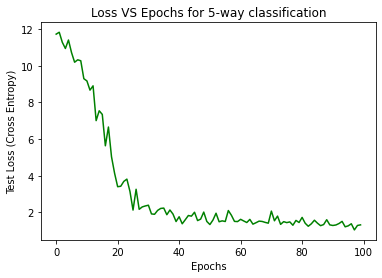

In [21]:
plt.plot(all_losses, 'green')
plt.xlabel('Epochs')
plt.ylabel('Test Loss (Cross Entropy)')
plt.title('Loss VS Epochs for 5-way classification')

## Fine-tuning

In [22]:
omni_test_path = join(project_path, r"omniglot-processed-5-test")
omni_test_train_datasets = dict()
omni_test_val_datasets = dict()

for name in listdir(omni_test_path):
    path = join(omni_test_path, name)
    if isdir(path):
        omni_test_train_datasets[name] = preprocessing.image_dataset_from_directory(path, label_mode='categorical',
                                                             color_mode='grayscale', batch_size=1000, image_size=(28,28),
                                                             seed=seed, validation_split=0.75, subset="training")
        omni_test_val_datasets[name] = preprocessing.image_dataset_from_directory(path, label_mode='categorical',
                                                             color_mode='grayscale', batch_size=1000, image_size=(28,28),
                                                             seed=seed, validation_split=0.75, subset="validation")

Found 100 files belonging to 5 classes.
Using 25 files for training.
Found 100 files belonging to 5 classes.
Using 75 files for validation.
Found 100 files belonging to 5 classes.
Using 25 files for training.
Found 100 files belonging to 5 classes.
Using 75 files for validation.
Found 100 files belonging to 5 classes.
Using 25 files for training.
Found 100 files belonging to 5 classes.
Using 75 files for validation.
Found 100 files belonging to 5 classes.
Using 25 files for training.
Found 100 files belonging to 5 classes.
Using 75 files for validation.
Found 100 files belonging to 5 classes.
Using 25 files for training.
Found 100 files belonging to 5 classes.
Using 75 files for validation.


In [23]:
omni_test_train_data = []
omni_test_train_labels = []
omni_test_val_data = []
omni_test_val_labels = []

for i in omni_test_train_datasets.keys():
    xs,ys = dataset_to_tensors(omni_test_train_datasets[i])
    omni_test_train_data.append(xs)
    omni_test_train_labels.append(ys)
    print('Test train dataset converted')
    xs,ys = dataset_to_tensors(omni_test_val_datasets[i])
    omni_test_val_data.append(xs)
    omni_test_val_labels.append(ys)
    print('Test val dataset converted')

Test train dataset converted
Test val dataset converted
Test train dataset converted
Test val dataset converted
Test train dataset converted
Test val dataset converted
Test train dataset converted
Test val dataset converted
Test train dataset converted
Test val dataset converted


In [33]:
sanskrit_fine_tuning_data = omni_test_train_data[2]
sanskrit_fine_tuning_labels = omni_test_train_labels[2]

sanskrit_val_data = omni_test_val_data[2]
sanskrit_val_labels = omni_test_val_labels[2]

# model_sanskrit = create_model()
# model_sanskrit.set_weights(model.get_weights())

In [39]:
model_sanskrit = keras.models.load_model('saved_models_5way/full_maml_model_5way')

In [44]:
model_sanskrit.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')
model_sanskrit.fit(sanskrit_fine_tuning_data, sanskrit_fine_tuning_labels, epochs=50, verbose=2)

Epoch 1/50
1/1 - 0s - loss: 7.1526e-07 - accuracy: 1.0000
Epoch 2/50
1/1 - 0s - loss: 6.7711e-07 - accuracy: 1.0000
Epoch 3/50
1/1 - 0s - loss: 6.6280e-07 - accuracy: 1.0000
Epoch 4/50
1/1 - 0s - loss: 6.1989e-07 - accuracy: 1.0000
Epoch 5/50
1/1 - 0s - loss: 5.8174e-07 - accuracy: 1.0000
Epoch 6/50
1/1 - 0s - loss: 5.4836e-07 - accuracy: 1.0000
Epoch 7/50
1/1 - 0s - loss: 5.1022e-07 - accuracy: 1.0000
Epoch 8/50
1/1 - 0s - loss: 4.8161e-07 - accuracy: 1.0000
Epoch 9/50
1/1 - 0s - loss: 4.5300e-07 - accuracy: 1.0000
Epoch 10/50
1/1 - 0s - loss: 4.3392e-07 - accuracy: 1.0000
Epoch 11/50
1/1 - 0s - loss: 4.1008e-07 - accuracy: 1.0000
Epoch 12/50
1/1 - 0s - loss: 3.7670e-07 - accuracy: 1.0000
Epoch 13/50
1/1 - 0s - loss: 3.5286e-07 - accuracy: 1.0000
Epoch 14/50
1/1 - 0s - loss: 3.4332e-07 - accuracy: 1.0000
Epoch 15/50
1/1 - 0s - loss: 3.3855e-07 - accuracy: 1.0000
Epoch 16/50
1/1 - 0s - loss: 3.2902e-07 - accuracy: 1.0000
Epoch 17/50
1/1 - 0s - loss: 3.1471e-07 - accuracy: 1.0000
Epoch 

In [45]:
model_sanskrit.evaluate(sanskrit_val_data, sanskrit_val_labels)

3/3 [==============================] - 0s 42ms/step - loss: 1.8159 - accuracy: 0.2133


[1.8159493207931519, 0.2133333384990692]

In [30]:
model_sanskrit_meow = create_model()
model_sanskrit_meow.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')
model_sanskrit_meow.fit(sanskrit_fine_tuning_data, sanskrit_fine_tuning_labels, epochs=100, verbose=2)

Epoch 1/100
1/1 - 0s - loss: 2.2844 - accuracy: 0.3200
Epoch 2/100
1/1 - 0s - loss: 0.4061 - accuracy: 0.9600
Epoch 3/100
1/1 - 0s - loss: 0.0689 - accuracy: 1.0000
Epoch 4/100
1/1 - 0s - loss: 0.0226 - accuracy: 1.0000
Epoch 5/100
1/1 - 0s - loss: 0.0120 - accuracy: 1.0000
Epoch 6/100
1/1 - 0s - loss: 0.0077 - accuracy: 1.0000
Epoch 7/100
1/1 - 0s - loss: 0.0055 - accuracy: 1.0000
Epoch 8/100
1/1 - 0s - loss: 0.0041 - accuracy: 1.0000
Epoch 9/100
1/1 - 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 10/100
1/1 - 0s - loss: 0.0027 - accuracy: 1.0000
Epoch 11/100
1/1 - 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 12/100
1/1 - 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 13/100
1/1 - 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 14/100
1/1 - 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 15/100
1/1 - 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 16/100
1/1 - 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 17/100
1/1 - 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 18/100
1/1 - 0s - loss: 0.0012 - accuracy: 1.0000
E

In [37]:
model_sanskrit_meow.evaluate(sanskrit_val_data, sanskrit_val_labels)

3/3 [==============================] - 0s 38ms/step - loss: 1.5671 - accuracy: 0.4133


[1.5671100616455078, 0.41333332657814026]